### Классификация текста

Одной из широко используемых задач NLP в различных бизнес-задачах является “классификация текста”. Цель классификации текста состоит в том, чтобы автоматически классифицировать текстовые документы по одной или нескольким определенным категориям. Некоторые примеры классификации текста:
- Определенеие настроений аудитории из социальных сетей
- Обнаружение спама и нежелательных писем
- Автоматическая маркировка запросов клиентов
- Категоризация новостных статей по определенным темам

Классификация текста является примером задачи машинного обучения с учителем, поскольку для обучения классификатора используется помеченный набор данных, содержащий текстовые документы и их метки. Пайплайн классификации текста состоит из 4 основных частей:
1. Подготовка данных
2. Генерация признаков
3. Тренировка модели
4. Оценка и тьюнинг модели

Проделаем данные шаги.

In [5]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas, numpy, textblob, string
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [6]:
import warnings
warnings.filterwarnings("ignore")

#### Подготовка датасета

В качестве датасета возьмем набор данных Amazon reviews. Набор данных состоит из 3,6 млн текстовых обзоров и их меток, мы будем использовать только небольшую часть данных. Датасет содержит 'text' текст отзыва и 'label' метку.

In [7]:
# Загружаем данные
data = open('corpus').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# создаем df
trainDF = pandas.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels

In [8]:
trainDF.head(5)

,text,label
0,Stuning even for the non-gamer: This sound tra...,__label__2
1,The best soundtrack ever to anything.: I'm rea...,__label__2
2,Amazing!: This soundtrack is my favorite music...,__label__2
3,Excellent Soundtrack: I truly like this soundt...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After He...",__label__2


#### Предобработка текста

Сделаем некоторую базовую предобработку текста: 
- уберем апострофы
- уберем специальные символы
- приведем к нижнему регистру
- сделаем токенизацию
- уберем стоп-слова 
- сделаем лемматизацию

In [10]:
def removeApostrophe(review):
    phrase = re.sub(r"won't", "will not", review)
    phrase = re.sub(r"can\'t", "can not", review)
    phrase = re.sub(r"n\'t", " not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

def removeApostropheFixed(review):
    phrase = re.sub(r"won't", "willnot", review)
    phrase = re.sub(r"can\'t", "cannot", review)
    phrase = re.sub(r"\snot", "not", review)
    phrase = re.sub(r"n\'t", "not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

def removeSpecialChars(review):
     return re.sub('[^a-zA-Z]', ' ', review)
    
def doCleaningFixed(review):
    review = removeApostropheFixed(review)
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

def doTextCleaning(review):
    review = removeApostrophe(review)
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

In [11]:
text = "I won't fdfd \'m  ase\'re can\'t"

In [12]:
removeApostrophe(text)

"I won't fdfd  am  ase're can't"

In [18]:
trainDF['textOld'] = trainDF['text'].apply(doTextCleaning)
trainDF['textNew'] = trainDF['text'].apply(doCleaningFixed)

In [90]:
trainDF['textOld'].head(20)

0     stuning even non gamer sound track beautiful p...
1     best soundtrack ever anything reading lot revi...
2     amazing soundtrack favorite music time hand in...
3     excellent soundtrack truly like soundtrack enj...
4     remember pull jaw floor hearing played game kn...
5     absolute masterpiece quite sure actually takin...
6     buyer beware self published book want know rea...
7     glorious story loved whisper wicked saint stor...
8     five star book finished reading whisper wicked...
9     whisper wicked saint easy read book made want ...
10    worst complete waste time typographical error ...
11    great book great book could put could read fas...
12    great read thought book brilliant yet realisti...
13    oh please guess romance novel lover one discer...
14    awful beyond belief feel write keep others was...
15    try fool u fake review glaringly obvious glowi...
16    romantic zen baseball comedy hear folk say mak...
17    fashionable compression stocking dvt docto

In [91]:
trainDF['textNew'].head(20)

0     stuning even non gamer sound track beautiful p...
1     best soundtrack ever anything reading lot revi...
2     amazing soundtrack favorite music time hand in...
3     excellent soundtrack truly like soundtrack enj...
4     remember pull jaw floor hearing played game kn...
5     absolute masterpiece quite sure actually takin...
6     buyer beware self published book want know rea...
7     glorious story loved whisper wicked saint stor...
8     five star book finished reading whisper wicked...
9     whisper wicked saint easy read book made want ...
10    worst complete waste time typographical error ...
11    great book great book could put could read fas...
12    great read thought book brilliant yet realisti...
13    oh please guess romance novel lover one discer...
14    awful beyond belief feel write keep others was...
15    try fool u fake review glaringly obvious glowi...
16    romantic zen baseball comedy hear folk say mak...
17    fashionable compression stocking dvt docto

In [21]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['textOld'], trainDF['label'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

#### Feature Engineering

На этом этапе необработанные текстовые данные будут преобразованы в векторы признаков, а новые признаки будут созданы с использованием существующего набора данных. Мы реализуем следующие идеи, чтобы получить релевантные признаки из нашего набора данных:

- Count вектора как признаки
- TF-IDF вектора как признаки
  - Word level
  - N-Gram level
  - Character level
- Text / NLP признаки

##### Count Vectors
Count Vector - это матричная нотация набора данных, в которой каждая строка представляет документ из корпуса, каждый столбец представляет термин из корпуса, а каждая ячейка представляет счетчик частот конкретного термина в конкретном документе.

In [24]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['textOld'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

##### TF-IDF вектора

Оценка TF-IDF представляет собой относительную важность термина в документе и во всем корпусе. 

TF (t) = (количество раз, когда термин t появляется в документе) / (общее количество терминов в документе)
IDF (t) = log_e(общее количество документов / количество документов с термином t в нем).

Векторы TF-IDF могут быть сгенерированы на разных уровнях входных токенов (слова, символы, n-граммы).

- Word Level TF-IDF : матрица содержит tf-idf оценки каждого слова в разных документах 
- N-gram Level TF-IDF : N-грам - комбинация N слов вместе. Матрица содержит tf-idf оценки N-грамов.
- Character Level TF-IDF : матрица содержит tf-idf оценки N-грам символов.

In [26]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['textOld'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['textOld'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['textOld'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [27]:
xtrain_tfidf_ngram_chars.todense()

matrix([[0.03173633, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01087033, 0.        , 0.0308865 , ..., 0.        , 0.        ,
         0.        ],
        [0.06729893, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.0818147 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [31]:
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))

In [98]:
trainDF.groupby("label")['word_count'].median()

label
__label__1    74
__label__2    68
Name: word_count, dtype: int64

##### Text / NLP признаки

Можно создать ряд дополнительных текстовых функций, которые иногда полезны для улучшения моделей классификации текста. Вот некоторые примеры:

1. Word Count документов – Общее количество слов в документе
2. Character Count документов – общее количество символов в документе
3. Average Word Density документов – средняя длина слов в документе
4. Puncutation Count – общее количество символов пунктуции в документе
5. Upper Case Count – общее количество слов с верхним регистром в документе
6. Title Word Count – общее количество заголовков  в документе
7. Частотное распределение тэгов частей речи:
  - Noun Count - количество существительных
  - Verb Count - количество глаголов
  - Adjective Count - количество прилагательных
  - Adverb Count - количество наречий
  - Pronoun Count - количество местоимений
  
Эти признаки довольно экспериментальны.

In [33]:
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [34]:
trainDF[['char_count', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 'upper_case_word_count' ]]

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,426,80,5.259259,11,10,3
1,509,97,5.193878,14,7,3
2,760,129,5.846154,40,24,4
3,743,118,6.243697,33,52,4
4,481,87,5.465909,22,30,0
...,...,...,...,...,...,...
9995,867,152,5.666667,25,14,3
9996,861,141,6.063380,14,16,0
9997,650,108,5.963303,17,11,0
9998,135,27,4.821429,6,2,1


In [35]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# подсчет тэгов частей речи в предложении
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [36]:
trainDF[['noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]

,noun_count,verb_count,adj_count,adv_count,pron_count
0,20,15,6,6,11
1,20,23,9,3,10
2,39,18,13,10,11
3,52,12,9,2,7
4,31,13,7,2,9
...,...,...,...,...,...
9995,46,24,13,10,5
9996,49,15,14,5,3
9997,30,18,14,2,8
9998,3,10,1,4,4


#### Построение моделей

Последний шаг в процессе классификации текста - это обучение классификатора с использованием признаков, созданных на предыдущем шаге. Опробуем несколько вариантов моделей машинного обучения.

In [46]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

##### Naive Bayes

Наивный Байес - это метод классификации, основанный на теореме Байеса с допущением независимости между предикторами. Наивный байесовский классификатор предполагает, что наличие определенного признака в классе не связано с наличием какого-либо другого признака в нем.

In [47]:
# Naive Bayes на Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes на Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes на Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes на Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)


NB, Count Vectors:  0.8448
NB, WordLevel TF-IDF:  0.8496
NB, N-Gram Vectors:  0.7728
NB, CharLevel Vectors:  0.8052


In [48]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(xtrain_tfidf_ngram_chars, train_y)    
predictions = classifier.predict(xvalid_tfidf_ngram_chars)
predictions

array([1, 0, 1, ..., 1, 0, 1])

 ##### Linear Classifier (Логистическая регрессия)
 
Логистическая регрессия измеряет связь между категориальной зависимой переменной и одной или несколькими независимыми переменными путем оценки вероятностей, используя логистическую/сигмоидную функцию. 

In [49]:
trainDF['label'].value_counts()

__label__1    5097
__label__2    4903
Name: label, dtype: int64

In [50]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier на Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)


LR, Count Vectors:  0.8508
LR, WordLevel TF-IDF:  0.8652
LR, N-Gram Vectors:  0.7676
LR, CharLevel Vectors:  0.8204


##### SVM

SVM -  алгоритм машинного обучения с учителем, который может быть использован как для классификации, так и для регрессии. Модель извлекает наилучшую возможную гиперплоскость/линию, которая разделяет эти два класса.

In [51]:
# SVM на Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)


SVM, N-Gram Vectors:  0.7632


##### RandomForest

Cлучайный лес - ансамбль решающих деревьев.

In [52]:
from tqdm import tqdm_notebook

In [53]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [54]:
# RF на Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF на Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)


RF, Count Vectors:  0.8492
RF, WordLevel TF-IDF:  0.8252


##### Boosting Model

Бустинг - процедура последовательного построения композиции алгоритмов машинного обучения, когда каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

In [72]:
import xgboost

In [74]:
# Extereme Gradient Boosting на Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting на Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting на Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)


Xgb, Count Vectors:  0.8348
Xgb, WordLevel TF-IDF:  0.8092
Xgb, CharLevel Vectors:  0.7968


### Анализ тональности

Другая задача NLP - анализ тональности текста. Анализ тональности - определение полярности эмоциональных оценок в исследуемом тексте, который содержит мнения, суждения, эмоции, отношение автора к сущностям, личностям, вопросам, событиям, темам и их атрибутам.

С помощью SentimentIntensityAnalyzer определим тональность отзывов.

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sent_analysis = trainDF['text'].apply(sid.polarity_scores)
sent_analysis

0       {'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co...
1       {'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co...
2       {'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...
3       {'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com...
4       {'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...
                              ...                        
9995    {'neg': 0.017, 'neu': 0.846, 'pos': 0.136, 'co...
9996    {'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...
9997    {'neg': 0.096, 'neu': 0.768, 'pos': 0.137, 'co...
9998    {'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...
9999    {'neg': 0.028, 'neu': 0.811, 'pos': 0.161, 'co...
Name: text, Length: 10000, dtype: object

In [60]:
print(trainDF['text'][0])
print(sent_analysis[0])


Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'compound': 0.9454}


In [34]:
print(trainDF['text'][10])
print(sent_analysis[10])


worst complete waste time typographical errors poor grammar totally pathetic plot add absolutely nothing embarrass author disappoint actually pay book
{'neg': 0.52, 'neu': 0.351, 'pos': 0.129, 'compound': -0.9241}


#### Data Visualization

В заключении отобразим 
- самые популярные слова всех отзывов
- самые популярные слова положительных отзывов
- самые популярные слова отрицательных отзывов
в видео облака слов с помощью WordCloud.

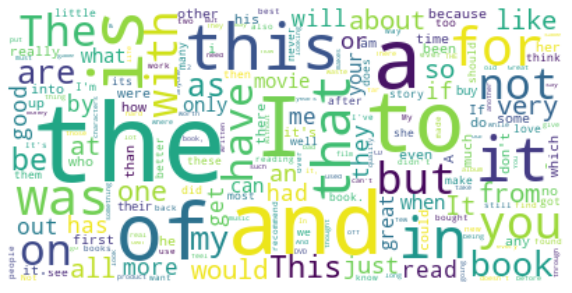

In [61]:
import collections

words = []
for line in trainDF['text']: 
    line_words = line.split()
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

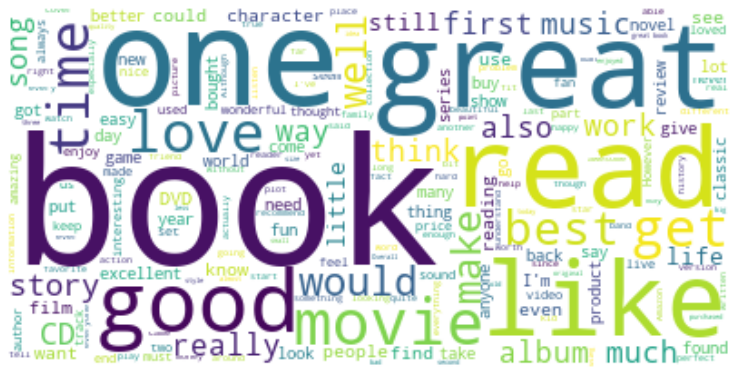

In [62]:
pos_words = []
for line in trainDF['text'][trainDF['label']=='__label__2']: 
    line_words = line.split()
    pos_words.extend(line_words)
pos_words = ' '.join(pos_words)

stopwords_set = set(stopwords.words('english'))
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(pos_words)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

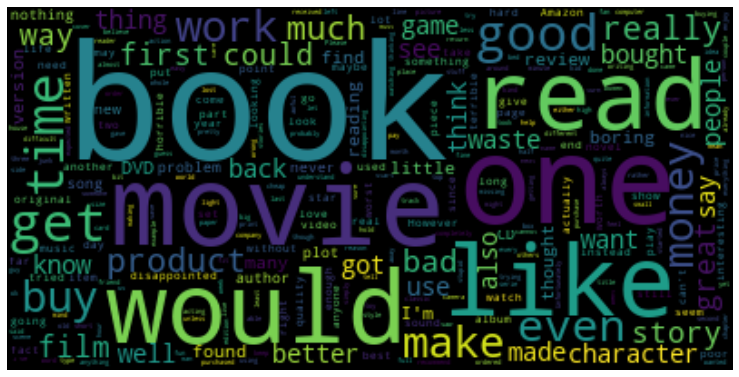

In [63]:
negative = [r for r in trainDF['text'][trainDF['label']=='__label__1']]
neg = ''.join(negative)
# draw a Word Cloud with word frequencies
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(
    background_color='black',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(neg)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Попробуем на русском

In [9]:
import pandas as pd
data = pd.read_excel("отзывы за лето.xls")

In [10]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [11]:
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = (data['Rating'] > 3)*1

In [12]:
data['target'] = data['target'].astype(int)
data.head()

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,в целое удобноной приложениеиз минус хотеть сл...,1
2,5,Отлично все,2017-08-14,отлично всё,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать на 1 работа антивирус далёкий н...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,1


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
data['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=13, stratify=data['target'])

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

In [17]:
count_vect = HashingVectorizer(n_features=200).fit(X_train.values)

In [18]:
xtrain = count_vect.transform(X_train)
xtest = count_vect.transform(X_test)

In [19]:
xtrain

<15798x200 sparse matrix of type '<class 'numpy.float64'>'
	with 97415 stored elements in Compressed Sparse Row format>

In [20]:
lr = linear_model.LogisticRegression(class_weight="balanced").fit(xtrain, y_train)

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
roc_auc_score(y_test, lr.predict_proba(xtest)[:, 1])

0.9252596079012712